# U-Net Cloud Removal - QUICK TEST VERSION
## Reduced sampling and epochs for fast testing

### Changes from full version:
- **Smaller crops**: 128x128 instead of 256x256
- **Fewer samples**: Limited dataset
- **Fewer epochs**: 10 instead of 20+
- **Smaller batch size**: For faster iteration
- **Added gamma monitoring**: To verify the fix works

### What to look for:
1. Gamma should grow from ~0.0 to ~0.01-0.1 over 10 epochs
2. Loss should decrease
3. Output should differ from input by epoch 5+
4. Some cloud removal should be visible

In [26]:
!pip install numpy 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# ============================================================
# Core Python
# ============================================================
import os
import numpy as np
from PIL import Image

# ============================================================
# Torch
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Albumentations
# ============================================================
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ============================================================
# TIFF Reader
# ============================================================
import rasterio

# ============================================================
# Visualization
# ============================================================
import matplotlib.pyplot as plt

# ============================================================
# Progress bar
# ============================================================
from tqdm import tqdm

# ============================================================
# Image quality metrics
# ============================================================
from skimage.metrics import peak_signal_noise_ratio as psnr_fn
from skimage.metrics import structural_similarity as ssim_fn

Device: cuda


In [28]:
def load_tif(path, scale_reflectance=True):
    """
    Load a multi-band TIFF using rasterio -> returns H x W x C (float32).
    If scale_reflectance=True, divides by 10000 (typical Sentinel-2 scaling).
    """
    with rasterio.open(path) as src:
        arr = src.read()         # (C, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # (H, W, C)

    arr = arr.astype(np.float32)
    if scale_reflectance:
        # Avoid dividing by zero; scale to [0, 1] approx
        arr = arr / 10000.0
    return arr

In [29]:
class ROIDataset(Dataset):
    """
    Loads ONLY the specified ROI folder (e.g., ROIs1868_73) 
    and all patch folders inside it.
    
    QUICK TEST VERSION: Can limit number of samples
    """
    def __init__(self, root_dir, roi_name="ROIs1868_73", transform=None, max_samples=None):
        self.root_dir = root_dir
        self.roi_name = roi_name
        self.transform = transform
        self.samples = []

        # Go to only this ROI
        roi_path = os.path.join(root_dir, roi_name)

        if not os.path.isdir(roi_path):
            raise ValueError(f"ROI folder not found: {roi_path}")

        # Scan patch folders inside the selected ROI
        for patch_folder in sorted(os.listdir(roi_path)):
            patch_path = os.path.join(roi_path, patch_folder)
            if not os.path.isdir(patch_path):
                continue

            agg, tgt = None, None

            for fname in os.listdir(patch_path):
                fname_up = fname.upper()
                if "FMASK_COMPOSITE" in fname_up:
                    agg = os.path.join(patch_path, fname)
                if "CLEAN_TARGET" in fname_up:
                    tgt = os.path.join(patch_path, fname)

            if agg and tgt:
                self.samples.append({"agg": agg, "tgt": tgt})
                
                # QUICK TEST: Limit samples if specified
                if max_samples and len(self.samples) >= max_samples:
                    break

        print(f"Loaded ROI: {roi_name}")
        print("Total samples found:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        X = load_tif(s["agg"])
        Y = load_tif(s["tgt"])

        # Keep first 13 channels
        if X.shape[2] > 13: X = X[..., :13]
        if Y.shape[2] > 13: Y = Y[..., :13]

        # Resize target if size mismatch
        if X.shape[:2] != Y.shape[:2]:
            bands = []
            for b in range(Y.shape[2]):
                band = (Y[..., b] * 10000).astype(np.uint16)
                band_pil = Image.fromarray(band)
                band_resized = np.array(
                    band_pil.resize((X.shape[1], X.shape[0]), resample=Image.BILINEAR)
                ).astype(np.float32) / 10000.0
                bands.append(band_resized)
            Y = np.stack(bands, axis=-1)

        # Albumentations transforms
        aug = self.transform(image=X, mask=Y)
        X_t = aug["image"]
        Y_t = aug["mask"]

        # Ensure CHW for mask
        if Y_t.ndim == 3 and Y_t.shape[0] != 13:
            Y_t = Y_t.permute(2, 0, 1)

        return X_t.float(), Y_t.float()

In [30]:
# ============================================================
# QUICK TEST CONFIG
# ============================================================
QUICK_TEST = False  # Set to False for full training

if QUICK_TEST:
    CROP_SIZE = 128        # Smaller: 128x128 instead of 256x256
    MAX_SAMPLES = 50       # Use only 50 samples total
    BATCH_SIZE = 4         # Smaller batch
    NUM_EPOCHS = 50      # Just 10 epochs for testing
    print("⚡ QUICK TEST MODE ENABLED")
    print(f"  Crop: {CROP_SIZE}x{CROP_SIZE}")
    print(f"  Max samples: {MAX_SAMPLES}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Epochs: {NUM_EPOCHS}")
else:
    CROP_SIZE = 256
    MAX_SAMPLES = None
    BATCH_SIZE = 2
    NUM_EPOCHS = 80
    print("🐢 FULL TRAINING MODE")

# 13-band normalization
norm_mean = [0.0] * 13
norm_std  = [1.0] * 13

train_transform = A.Compose([
    A.RandomCrop(CROP_SIZE, CROP_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=norm_mean, std=norm_std, max_pixel_value=1.0),
    ToTensorV2()
])

val_transform = A.Compose([
    A.CenterCrop(CROP_SIZE, CROP_SIZE),
    A.Normalize(mean=norm_mean, std=norm_std, max_pixel_value=1.0),
    ToTensorV2()
])

root_path = r"D:\Timegate Images"

train_ds = ROIDataset(root_path, roi_name="ROIs1868_73", transform=train_transform, max_samples=MAX_SAMPLES)
val_ds   = ROIDataset(root_path, roi_name="ROIs1868_73", transform=val_transform, max_samples=10)  # Just 10 for validation

print("\nDataset created:")
print(f"  Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

🐢 FULL TRAINING MODE
Loaded ROI: ROIs1868_73
Total samples found: 240
Loaded ROI: ROIs1868_73
Total samples found: 10

Dataset created:
  Train samples: 240
  Val samples: 10
  Train batches: 120
  Val batches: 10


In [31]:
# ============================================================
# U-NET WITH RESIDUAL CONNECTION (FIXED VERSION)
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=13):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)
        
        # ✅ CRITICAL FIX: Learnable scalar gamma initialized to 0
        # This allows the model to start by outputting the input and gradually learn corrections
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        # ✅ Save input for residual connection
        input_x = x
        
        # Standard U-Net encoder-decoder
        c1 = self.down1(x); p1 = self.pool(c1)
        c2 = self.down2(p1); p2 = self.pool(c2)
        c3 = self.down3(p2); p3 = self.pool(c3)
        c4 = self.down4(p3); p4 = self.pool(c4)
        bn = self.bottleneck(p4)
        u4 = torch.cat([self.up4(bn), c4], dim=1); u4 = self.conv4(u4)
        u3 = torch.cat([self.up3(u4), c3], dim=1); u3 = self.conv3(u3)
        u2 = torch.cat([self.up2(u3), c2], dim=1); u2 = self.conv2(u2)
        u1 = torch.cat([self.up1(u2), c1], dim=1); u1 = self.conv1(u1)
        residual = self.out(u1)
        
        # ✅ CRITICAL FIX: Add residual connection (paper Equation 4)
        # Y_tilde = gamma * U-Net(X) + X
        # The U-Net learns what to ADD/SUBTRACT from the aggregated image, not the full output!
        return self.gamma * residual + input_x

model = UNet(in_channels=13, out_channels=13).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*60)
print("MODEL CREATED (WITH RESIDUAL CONNECTION FIX)")
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"✓ Has gamma parameter: {hasattr(model, 'gamma')}")
print(f"  Initial gamma value: {model.gamma.item():.10f}")
print("="*60)


MODEL CREATED (WITH RESIDUAL CONNECTION FIX)
Total parameters: 31,050,062
Trainable parameters: 31,050,062
✓ Has gamma parameter: True
  Initial gamma value: 0.0000000000


In [32]:
# ============================================================
# TRAINING SETUP
# ============================================================

def loss_fn(pred, target):
    """Combined L1 and MSE loss"""
    return F.l1_loss(pred, target) + 0.1 * F.mse_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# For tracking
train_losses = []
val_psnrs = []
val_ssims = []
gamma_history = []

def train_epoch():
    model.train()
    total = 0.0
    count = 0
    for X, Y in tqdm(train_loader, desc="Training"):
        X = X.to(device).float()
        Y = Y.to(device).float()
        pred = model(X)
        loss = loss_fn(pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
        count += 1
    return total / (count if count > 0 else 1.0)

def validate_epoch():
    """
    Returns PSNR and per-band averaged SSIM for 13-channel Sentinel-2 images.
    """
    model.eval()
    psnrs, ssims = [], []

    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device).float()
            Y = Y.to(device).float()

            # Forward pass
            pred = model(X)

            # Convert CHW -> HWC for numpy ops
            pred_np = pred.cpu().numpy()[0].transpose(1,2,0)
            Y_np    = Y.cpu().numpy()[0].transpose(1,2,0)

            # Clip range for PSNR/SSIM
            pred_np_clipped = np.clip(pred_np, 0.0, 1.0)
            Y_np_clipped    = np.clip(Y_np,   0.0, 1.0)

            # PSNR
            try:
                psnrs.append(psnr_fn(Y_np_clipped, pred_np_clipped, data_range=1.0))
            except:
                pass

            # SSIM per-band average
            ssim_vals = []
            for b in range(pred_np_clipped.shape[2]):  # 13 bands
                try:
                    ssim_vals.append(
                        ssim_fn(
                            Y_np_clipped[:,:,b],
                            pred_np_clipped[:,:,b],
                            data_range=1.0
                        )
                    )
                except:
                    pass

            if len(ssim_vals) > 0:
                ssims.append(np.mean(ssim_vals))

    return (
        np.mean(psnrs) if psnrs else 0.0,
        np.mean(ssims) if ssims else 0.0
    )

print("Training setup complete!")

Training setup complete!


In [33]:
# ============================================================
# TRAINING LOOP WITH GAMMA MONITORING
# ============================================================

print("\n" + "="*60)
print(f"STARTING TRAINING - {NUM_EPOCHS} EPOCHS")
print("="*60)
print("Watch for:")
print("  1. Gamma growing from ~0.0 to ~0.01-0.1")
print("  2. Loss decreasing")
print("  3. SSIM improving")
print("="*60)

best_ssim = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch()
    train_losses.append(train_loss)
    
    # Validate
    val_psnr, val_ssim = validate_epoch()
    val_psnrs.append(val_psnr)
    val_ssims.append(val_ssim)
    
    # Get gamma value
    gamma_val = model.gamma.item()
    gamma_history.append(gamma_val)
    
    # Print metrics with gamma
    print(f"  Loss: {train_loss:.6f} | PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.6f} | Gamma: {gamma_val:.8f}")
    
    # Check if gamma is growing
    if epoch > 1:
        gamma_growth = gamma_val - gamma_history[-2]
        if gamma_growth > 0:
            print(f"  ✓ Gamma growing (+{gamma_growth:.8f})")
        elif abs(gamma_growth) < 1e-10:
            print(f"  ⚠ Gamma not changing (stuck?)")
    
    # Save best model
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'ssim': val_ssim,
            'psnr': val_psnr,
            'gamma': gamma_val
        }, 'best_model.pth')
        print(f"  💾 Saved best checkpoint (SSIM: {val_ssim:.6f})")

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Best SSIM: {best_ssim:.6f}")
print(f"Final Gamma: {gamma_history[-1]:.8f}")
print(f"Gamma growth: {gamma_history[0]:.8f} → {gamma_history[-1]:.8f}")
print("="*60)


STARTING TRAINING - 80 EPOCHS
Watch for:
  1. Gamma growing from ~0.0 to ~0.01-0.1
  2. Loss decreasing
  3. SSIM improving

Epoch 1/80


Training: 100%|██████████| 120/120 [00:12<00:00,  9.98it/s]


  Loss: 0.027294 | PSNR: 29.99 | SSIM: 0.892284 | Gamma: 0.01099670
  💾 Saved best checkpoint (SSIM: 0.892284)

Epoch 2/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.43it/s]


  Loss: 0.026929 | PSNR: 32.42 | SSIM: 0.906368 | Gamma: 0.01074507
  💾 Saved best checkpoint (SSIM: 0.906368)

Epoch 3/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.39it/s]


  Loss: 0.026797 | PSNR: 32.76 | SSIM: 0.907530 | Gamma: 0.01005930
  💾 Saved best checkpoint (SSIM: 0.907530)

Epoch 4/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.45it/s]


  Loss: 0.026720 | PSNR: 30.01 | SSIM: 0.898411 | Gamma: 0.01089537
  ✓ Gamma growing (+0.00083607)

Epoch 5/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.45it/s]


  Loss: 0.026747 | PSNR: 31.12 | SSIM: 0.906236 | Gamma: 0.01026316

Epoch 6/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.38it/s]


  Loss: 0.026701 | PSNR: 32.75 | SSIM: 0.908870 | Gamma: 0.01025786
  💾 Saved best checkpoint (SSIM: 0.908870)

Epoch 7/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.37it/s]


  Loss: 0.026633 | PSNR: 32.14 | SSIM: 0.906061 | Gamma: 0.01037935
  ✓ Gamma growing (+0.00012149)

Epoch 8/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.34it/s]


  Loss: 0.026614 | PSNR: 30.90 | SSIM: 0.904641 | Gamma: 0.01091443
  ✓ Gamma growing (+0.00053508)

Epoch 9/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.026604 | PSNR: 30.13 | SSIM: 0.903154 | Gamma: 0.01029776

Epoch 10/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.18it/s]


  Loss: 0.026605 | PSNR: 32.51 | SSIM: 0.910078 | Gamma: 0.01367099
  ✓ Gamma growing (+0.00337322)
  💾 Saved best checkpoint (SSIM: 0.910078)

Epoch 11/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.30it/s]


  Loss: 0.026546 | PSNR: 30.40 | SSIM: 0.906935 | Gamma: 0.01297397

Epoch 12/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026456 | PSNR: 32.36 | SSIM: 0.910021 | Gamma: 0.00942041

Epoch 13/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.026564 | PSNR: 32.67 | SSIM: 0.910208 | Gamma: 0.01086392
  ✓ Gamma growing (+0.00144351)
  💾 Saved best checkpoint (SSIM: 0.910208)

Epoch 14/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.11it/s]


  Loss: 0.026531 | PSNR: 31.87 | SSIM: 0.910099 | Gamma: 0.01187674
  ✓ Gamma growing (+0.00101282)

Epoch 15/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026388 | PSNR: 32.09 | SSIM: 0.910044 | Gamma: 0.01157132

Epoch 16/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.026394 | PSNR: 32.65 | SSIM: 0.910677 | Gamma: 0.01144643
  💾 Saved best checkpoint (SSIM: 0.910677)

Epoch 17/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026489 | PSNR: 33.00 | SSIM: 0.911280 | Gamma: 0.01194245
  ✓ Gamma growing (+0.00049602)
  💾 Saved best checkpoint (SSIM: 0.911280)

Epoch 18/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.05it/s]


  Loss: 0.026447 | PSNR: 33.26 | SSIM: 0.911547 | Gamma: 0.01096744
  💾 Saved best checkpoint (SSIM: 0.911547)

Epoch 19/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.026442 | PSNR: 32.90 | SSIM: 0.911115 | Gamma: 0.01170719
  ✓ Gamma growing (+0.00073975)

Epoch 20/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026390 | PSNR: 32.32 | SSIM: 0.909874 | Gamma: 0.01368496
  ✓ Gamma growing (+0.00197777)

Epoch 21/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.17it/s]


  Loss: 0.026391 | PSNR: 30.13 | SSIM: 0.901147 | Gamma: 0.01237638

Epoch 22/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.25it/s]


  Loss: 0.026427 | PSNR: 32.70 | SSIM: 0.910933 | Gamma: 0.01093413

Epoch 23/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.07it/s]


  Loss: 0.026367 | PSNR: 33.19 | SSIM: 0.912873 | Gamma: 0.01277856
  ✓ Gamma growing (+0.00184444)
  💾 Saved best checkpoint (SSIM: 0.912873)

Epoch 24/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026332 | PSNR: 32.36 | SSIM: 0.910127 | Gamma: 0.01322822
  ✓ Gamma growing (+0.00044966)

Epoch 25/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.18it/s]


  Loss: 0.026338 | PSNR: 32.30 | SSIM: 0.910893 | Gamma: 0.01378407
  ✓ Gamma growing (+0.00055584)

Epoch 26/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.25it/s]


  Loss: 0.026306 | PSNR: 31.21 | SSIM: 0.909889 | Gamma: 0.01188288

Epoch 27/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.08it/s]


  Loss: 0.026337 | PSNR: 31.95 | SSIM: 0.910634 | Gamma: 0.01425598
  ✓ Gamma growing (+0.00237310)

Epoch 28/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.026338 | PSNR: 30.98 | SSIM: 0.907074 | Gamma: 0.01406165

Epoch 29/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.15it/s]


  Loss: 0.026324 | PSNR: 32.80 | SSIM: 0.912690 | Gamma: 0.01446811
  ✓ Gamma growing (+0.00040645)

Epoch 30/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.25it/s]


  Loss: 0.026173 | PSNR: 32.63 | SSIM: 0.910695 | Gamma: 0.01282877

Epoch 31/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026216 | PSNR: 30.75 | SSIM: 0.908391 | Gamma: 0.01493691
  ✓ Gamma growing (+0.00210814)

Epoch 32/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.30it/s]


  Loss: 0.026273 | PSNR: 30.97 | SSIM: 0.908064 | Gamma: 0.01274978

Epoch 33/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.16it/s]


  Loss: 0.026237 | PSNR: 32.96 | SSIM: 0.911994 | Gamma: 0.01464349
  ✓ Gamma growing (+0.00189370)

Epoch 34/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026247 | PSNR: 32.15 | SSIM: 0.912831 | Gamma: 0.01687860
  ✓ Gamma growing (+0.00223511)

Epoch 35/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026287 | PSNR: 32.47 | SSIM: 0.911160 | Gamma: 0.01279517

Epoch 36/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.14it/s]


  Loss: 0.026226 | PSNR: 32.42 | SSIM: 0.911606 | Gamma: 0.01502497
  ✓ Gamma growing (+0.00222981)

Epoch 37/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.026252 | PSNR: 33.29 | SSIM: 0.911009 | Gamma: 0.01332914

Epoch 38/80


Training: 100%|██████████| 120/120 [00:12<00:00,  9.95it/s]


  Loss: 0.026136 | PSNR: 31.21 | SSIM: 0.910322 | Gamma: 0.01499656
  ✓ Gamma growing (+0.00166742)

Epoch 39/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026144 | PSNR: 31.55 | SSIM: 0.910437 | Gamma: 0.01519898
  ✓ Gamma growing (+0.00020242)

Epoch 40/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.15it/s]


  Loss: 0.026104 | PSNR: 33.04 | SSIM: 0.912936 | Gamma: 0.01759278
  ✓ Gamma growing (+0.00239380)
  💾 Saved best checkpoint (SSIM: 0.912936)

Epoch 41/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.30it/s]


  Loss: 0.026208 | PSNR: 32.68 | SSIM: 0.907477 | Gamma: 0.01454498

Epoch 42/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.24it/s]


  Loss: 0.026133 | PSNR: 31.55 | SSIM: 0.907303 | Gamma: 0.01556353
  ✓ Gamma growing (+0.00101855)

Epoch 43/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


  Loss: 0.026066 | PSNR: 32.65 | SSIM: 0.911801 | Gamma: 0.01671028
  ✓ Gamma growing (+0.00114675)

Epoch 44/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.026128 | PSNR: 33.27 | SSIM: 0.908695 | Gamma: 0.01647102

Epoch 45/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.33it/s]


  Loss: 0.026041 | PSNR: 32.32 | SSIM: 0.912960 | Gamma: 0.01690231
  ✓ Gamma growing (+0.00043129)
  💾 Saved best checkpoint (SSIM: 0.912960)

Epoch 46/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026027 | PSNR: 32.73 | SSIM: 0.910981 | Gamma: 0.01689875

Epoch 47/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.21it/s]


  Loss: 0.026044 | PSNR: 33.13 | SSIM: 0.910250 | Gamma: 0.01569134

Epoch 48/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026123 | PSNR: 32.02 | SSIM: 0.912687 | Gamma: 0.01518793

Epoch 49/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.24it/s]


  Loss: 0.026058 | PSNR: 33.03 | SSIM: 0.912585 | Gamma: 0.01509847

Epoch 50/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.09it/s]


  Loss: 0.025976 | PSNR: 31.96 | SSIM: 0.908566 | Gamma: 0.01810274
  ✓ Gamma growing (+0.00300427)

Epoch 51/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.026037 | PSNR: 33.07 | SSIM: 0.905853 | Gamma: 0.01767729

Epoch 52/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.12it/s]


  Loss: 0.026007 | PSNR: 30.28 | SSIM: 0.906504 | Gamma: 0.01876707
  ✓ Gamma growing (+0.00108978)

Epoch 53/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.025948 | PSNR: 32.14 | SSIM: 0.911983 | Gamma: 0.01719691

Epoch 54/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.21it/s]


  Loss: 0.026033 | PSNR: 31.50 | SSIM: 0.907197 | Gamma: 0.01550175

Epoch 55/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.22it/s]


  Loss: 0.026009 | PSNR: 32.57 | SSIM: 0.910653 | Gamma: 0.01752128
  ✓ Gamma growing (+0.00201954)

Epoch 56/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.026079 | PSNR: 32.92 | SSIM: 0.913020 | Gamma: 0.01898847
  ✓ Gamma growing (+0.00146719)
  💾 Saved best checkpoint (SSIM: 0.913020)

Epoch 57/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.10it/s]


  Loss: 0.025785 | PSNR: 31.90 | SSIM: 0.912877 | Gamma: 0.01744013

Epoch 58/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.28it/s]


  Loss: 0.025950 | PSNR: 32.40 | SSIM: 0.913004 | Gamma: 0.01622899

Epoch 59/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


  Loss: 0.025736 | PSNR: 32.06 | SSIM: 0.912901 | Gamma: 0.02115506
  ✓ Gamma growing (+0.00492608)

Epoch 60/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.25it/s]


  Loss: 0.025941 | PSNR: 32.51 | SSIM: 0.910720 | Gamma: 0.01942716

Epoch 61/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.025881 | PSNR: 32.38 | SSIM: 0.912735 | Gamma: 0.01995455
  ✓ Gamma growing (+0.00052738)

Epoch 62/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.03it/s]


  Loss: 0.025908 | PSNR: 32.80 | SSIM: 0.912019 | Gamma: 0.02074036
  ✓ Gamma growing (+0.00078581)

Epoch 63/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


  Loss: 0.025902 | PSNR: 33.01 | SSIM: 0.913154 | Gamma: 0.02124896
  ✓ Gamma growing (+0.00050860)
  💾 Saved best checkpoint (SSIM: 0.913154)

Epoch 64/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.15it/s]


  Loss: 0.025930 | PSNR: 32.98 | SSIM: 0.912983 | Gamma: 0.02025235

Epoch 65/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.26it/s]


  Loss: 0.026039 | PSNR: 30.70 | SSIM: 0.907275 | Gamma: 0.01936078

Epoch 66/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.18it/s]


  Loss: 0.025852 | PSNR: 31.87 | SSIM: 0.908040 | Gamma: 0.02033453
  ✓ Gamma growing (+0.00097375)

Epoch 67/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.12it/s]


  Loss: 0.025943 | PSNR: 33.07 | SSIM: 0.910724 | Gamma: 0.02048380
  ✓ Gamma growing (+0.00014927)

Epoch 68/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.025696 | PSNR: 31.94 | SSIM: 0.913027 | Gamma: 0.02007682

Epoch 69/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


  Loss: 0.025898 | PSNR: 31.66 | SSIM: 0.909963 | Gamma: 0.01936652

Epoch 70/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.025934 | PSNR: 32.62 | SSIM: 0.911927 | Gamma: 0.01924323

Epoch 71/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.15it/s]


  Loss: 0.025837 | PSNR: 33.14 | SSIM: 0.913693 | Gamma: 0.02146612
  ✓ Gamma growing (+0.00222290)
  💾 Saved best checkpoint (SSIM: 0.913693)

Epoch 72/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


  Loss: 0.025885 | PSNR: 31.76 | SSIM: 0.908406 | Gamma: 0.02099769

Epoch 73/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.025755 | PSNR: 33.12 | SSIM: 0.912310 | Gamma: 0.02133279
  ✓ Gamma growing (+0.00033511)

Epoch 74/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.14it/s]


  Loss: 0.025729 | PSNR: 32.92 | SSIM: 0.912637 | Gamma: 0.02456802
  ✓ Gamma growing (+0.00323522)

Epoch 75/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.18it/s]


  Loss: 0.025666 | PSNR: 31.57 | SSIM: 0.910646 | Gamma: 0.02337798

Epoch 76/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.13it/s]


  Loss: 0.025720 | PSNR: 31.96 | SSIM: 0.912080 | Gamma: 0.02419145
  ✓ Gamma growing (+0.00081347)

Epoch 77/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.28it/s]


  Loss: 0.025725 | PSNR: 32.81 | SSIM: 0.910780 | Gamma: 0.02351641

Epoch 78/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


  Loss: 0.025482 | PSNR: 32.67 | SSIM: 0.911563 | Gamma: 0.02420166
  ✓ Gamma growing (+0.00068525)

Epoch 79/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.20it/s]


  Loss: 0.025831 | PSNR: 32.24 | SSIM: 0.911823 | Gamma: 0.02305753

Epoch 80/80


Training: 100%|██████████| 120/120 [00:11<00:00, 10.24it/s]


  Loss: 0.025842 | PSNR: 33.29 | SSIM: 0.911819 | Gamma: 0.02425684
  ✓ Gamma growing (+0.00119930)

TRAINING COMPLETE
Best SSIM: 0.913693
Final Gamma: 0.02425684
Gamma growth: 0.01099670 → 0.02425684


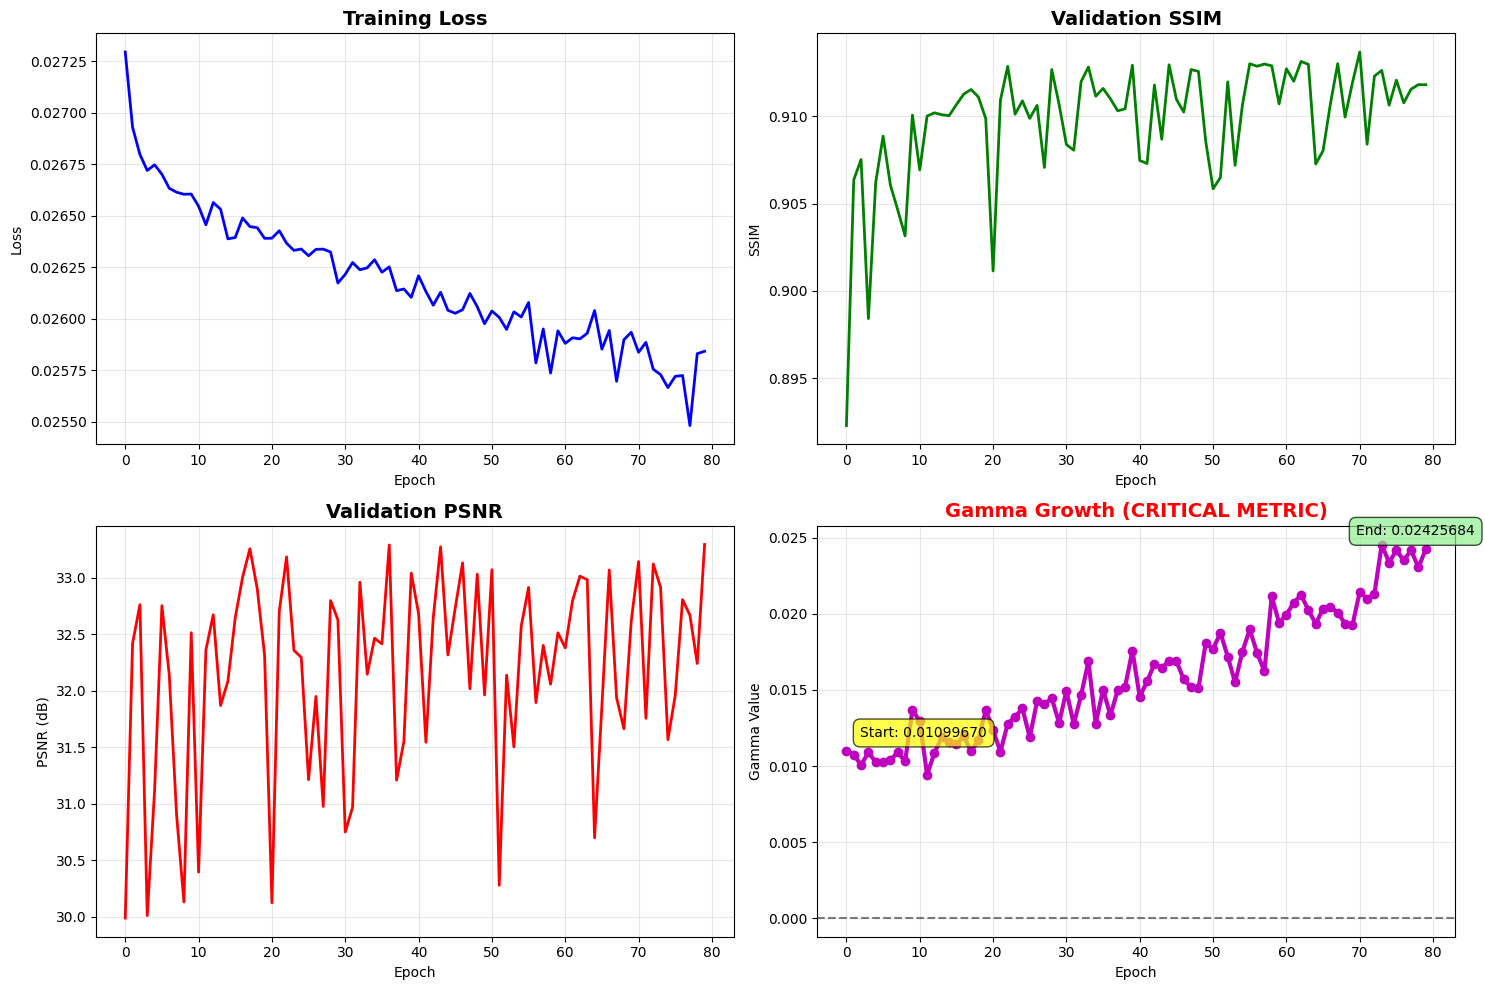


📊 Training metrics plotted!

🔍 GAMMA ANALYSIS:
  Initial: 0.0109967012
  Final: 0.0242568366
  Growth: 0.0132601354
  Growth rate: 120.6%
  ✓ Gamma is growing - Fix is working!


In [39]:
# ============================================================
# PLOT TRAINING METRICS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(train_losses, 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# SSIM
axes[0, 1].plot(val_ssims, 'g-', linewidth=2)
axes[0, 1].set_title('Validation SSIM', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('SSIM')
axes[0, 1].grid(True, alpha=0.3)

# PSNR
axes[1, 0].plot(val_psnrs, 'r-', linewidth=2)
axes[1, 0].set_title('Validation PSNR', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].grid(True, alpha=0.3)

# GAMMA - MOST IMPORTANT!
axes[1, 1].plot(gamma_history, 'm-', linewidth=3, marker='o', markersize=6)
axes[1, 1].set_title('Gamma Growth (CRITICAL METRIC)', fontsize=14, fontweight='bold', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Gamma Value')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Add annotations
if len(gamma_history) > 0:
    axes[1, 1].annotate(f'Start: {gamma_history[0]:.8f}', 
                        xy=(0, gamma_history[0]), 
                        xytext=(10, 10), 
                        textcoords='offset points',
                        fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7))
    axes[1, 1].annotate(f'End: {gamma_history[-1]:.8f}', 
                        xy=(len(gamma_history)-1, gamma_history[-1]), 
                        xytext=(-50, 10), 
                        textcoords='offset points',
                        fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Training metrics plotted!")
print("\n🔍 GAMMA ANALYSIS:")
print(f"  Initial: {gamma_history[0]:.10f}")
print(f"  Final: {gamma_history[-1]:.10f}")
print(f"  Growth: {(gamma_history[-1] - gamma_history[0]):.10f}")
print(f"  Growth rate: {((gamma_history[-1] / (gamma_history[0] + 1e-10)) - 1) * 100:.1f}%")

if gamma_history[-1] > 0.001:
    print("  ✓ Gamma is growing - Fix is working!")
elif gamma_history[-1] > 1e-6:
    print("  ⚠ Gamma is small but growing - May need more epochs")
else:
    print("  ❌ Gamma stuck at ~0 - Check implementation")

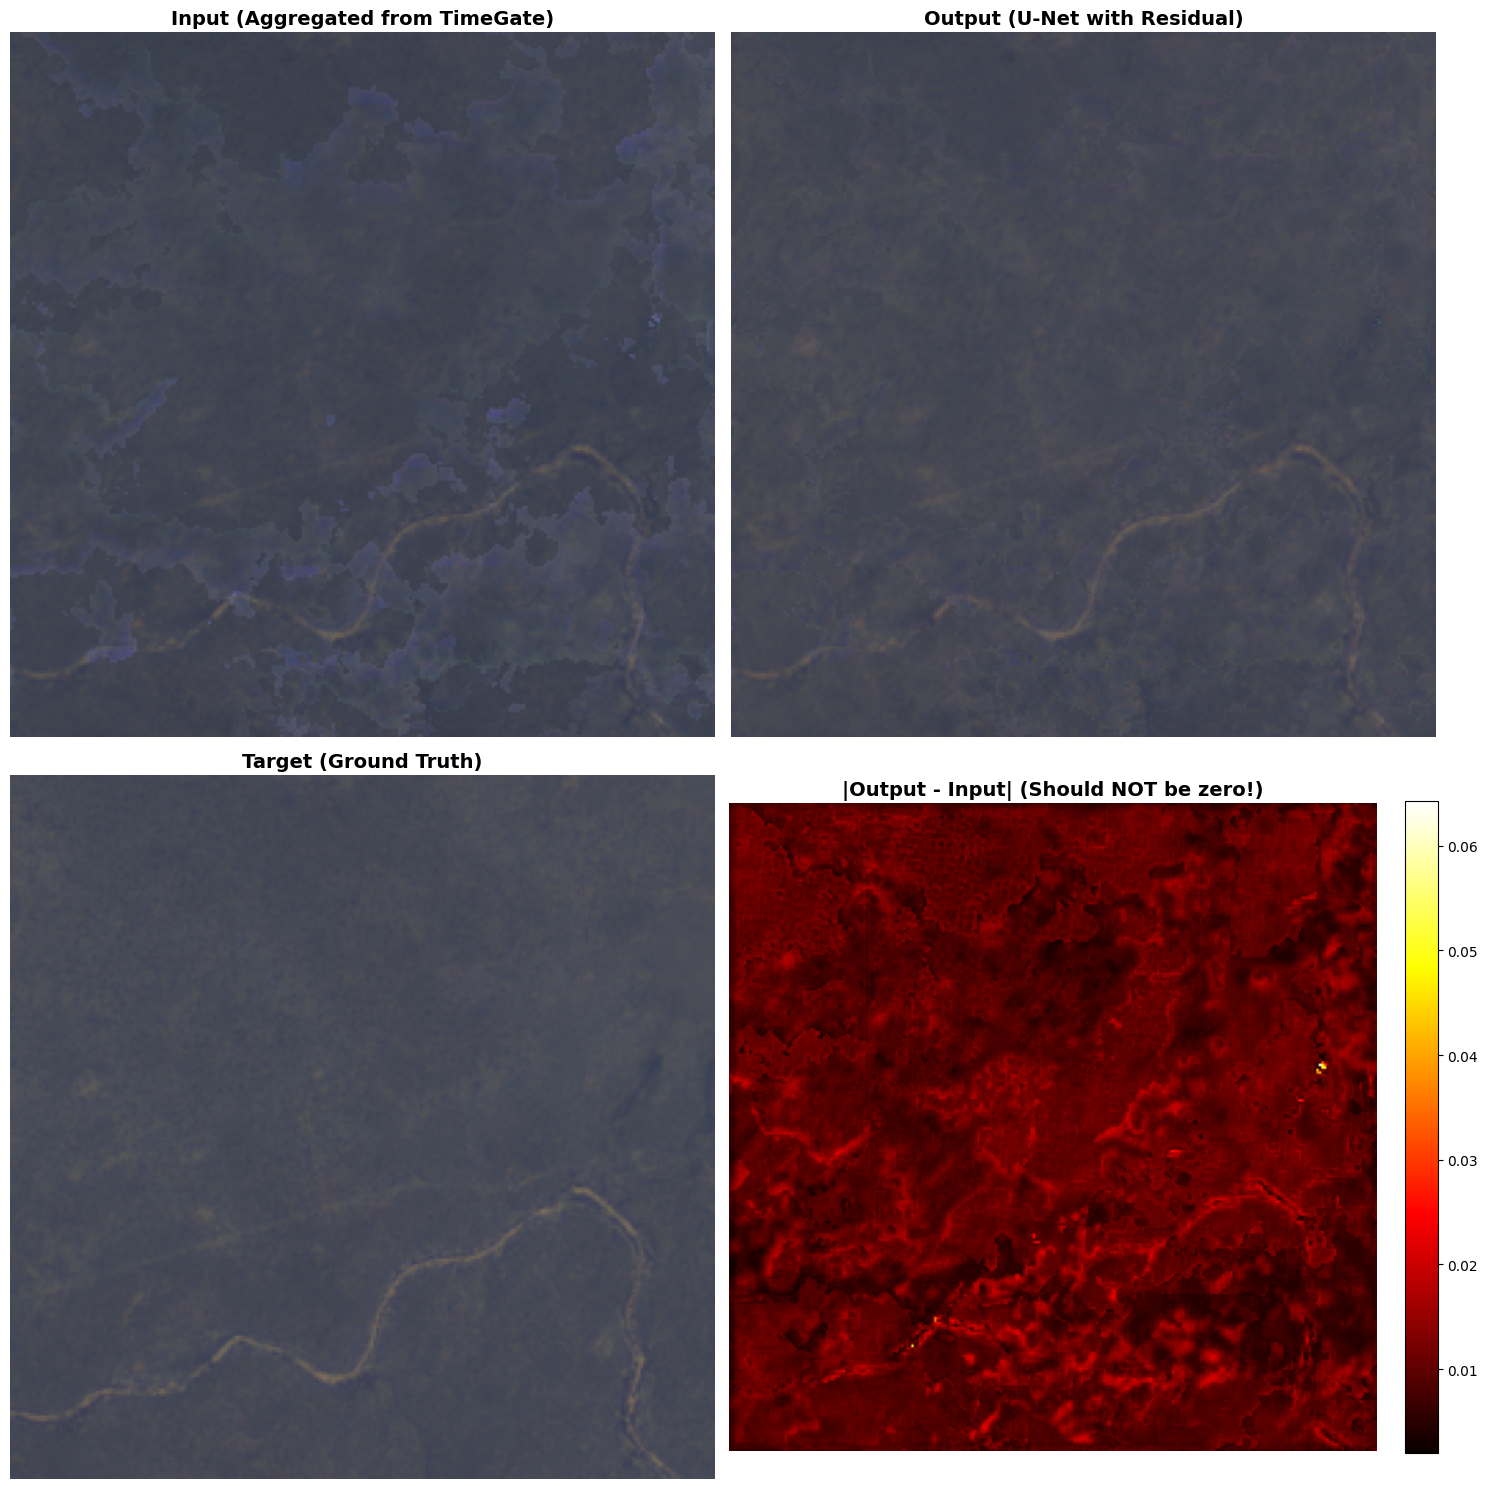


📸 VISUAL COMPARISON:
  Mean |Output - Input|: 0.009529
  Max |Output - Input|: 0.064246
  ⚠ Output differs slightly - May need more training

🎯 ACCURACY:
  Input error to target: 0.013652
  Output error to target: 0.007246
  Improvement: 0.006407 (better than input)


In [40]:
# ============================================================
# VISUALIZE PREDICTIONS
# ============================================================

def to_rgb(img_chw, enhance=2.5):
    """Convert 13-band CHW to RGB for visualization"""
    # Use bands 3,2,1 (Red, Green, Blue for Sentinel-2)
    rgb = img_chw[[2,1,0], :, :].cpu().numpy().transpose(1,2,0)
    rgb = np.clip(rgb * enhance, 0, 1)
    return rgb

model.eval()

# Get a sample
sample_X, sample_Y = next(iter(val_loader))
sample_X = sample_X.to(device)
sample_Y = sample_Y.to(device)

with torch.no_grad():
    sample_pred = model(sample_X)

# Create comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Input (aggregated)
axes[0, 0].imshow(to_rgb(sample_X[0]))
axes[0, 0].set_title('Input (Aggregated from TimeGate)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Output (U-Net)
axes[0, 1].imshow(to_rgb(sample_pred[0]))
axes[0, 1].set_title('Output (U-Net with Residual)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Target (ground truth)
axes[1, 0].imshow(to_rgb(sample_Y[0]))
axes[1, 0].set_title('Target (Ground Truth)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Difference map
diff = torch.abs(sample_pred[0] - sample_X[0]).mean(dim=0).cpu().numpy()
im = axes[1, 1].imshow(diff, cmap='hot')
axes[1, 1].set_title('|Output - Input| (Should NOT be zero!)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate difference metrics
diff_mean = diff.mean()
diff_max = diff.max()

print("\n📸 VISUAL COMPARISON:")
print(f"  Mean |Output - Input|: {diff_mean:.6f}")
print(f"  Max |Output - Input|: {diff_max:.6f}")

if diff_mean > 0.01:
    print("  ✓ Output significantly differs from input - U-Net is learning!")
elif diff_mean > 0.001:
    print("  ⚠ Output differs slightly - May need more training")
else:
    print("  ❌ Output ≈ Input - Model not learning corrections")

# Compare with target
error_to_target = torch.abs(sample_pred - sample_Y).mean().item()
input_error_to_target = torch.abs(sample_X - sample_Y).mean().item()
improvement = input_error_to_target - error_to_target

print("\n🎯 ACCURACY:")
print(f"  Input error to target: {input_error_to_target:.6f}")
print(f"  Output error to target: {error_to_target:.6f}")
print(f"  Improvement: {improvement:.6f} ({'better' if improvement > 0 else 'worse'} than input)")

In [36]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*70)
print("QUICK TEST SUMMARY")
print("="*70)

print("\n📊 TRAINING RESULTS:")
print(f"  Epochs trained: {NUM_EPOCHS}")
print(f"  Initial loss: {train_losses[0]:.6f}")
print(f"  Final loss: {train_losses[-1]:.6f}")
print(f"  Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
print(f"  Best SSIM: {best_ssim:.6f}")

print("\n🎯 GAMMA TRACKING (KEY INDICATOR):")
print(f"  Initial gamma: {gamma_history[0]:.10f}")
print(f"  Final gamma: {gamma_history[-1]:.10f}")
print(f"  Total growth: {(gamma_history[-1] - gamma_history[0]):.10f}")

# Verdict
print("\n✅ FIX VERIFICATION:")
checks_passed = 0
total_checks = 4

# Check 1: Has gamma parameter
if hasattr(model, 'gamma'):
    print("  ✓ Model has gamma parameter")
    checks_passed += 1
else:
    print("  ❌ Model missing gamma parameter")

# Check 2: Gamma is growing
if gamma_history[-1] > gamma_history[0]:
    print("  ✓ Gamma is growing")
    checks_passed += 1
else:
    print("  ❌ Gamma not growing")

# Check 3: Loss is decreasing
if train_losses[-1] < train_losses[0]:
    print("  ✓ Loss is decreasing")
    checks_passed += 1
else:
    print("  ❌ Loss not decreasing")

# Check 4: Output differs from input
if diff_mean > 0.001:
    print("  ✓ Output differs from input")
    checks_passed += 1
else:
    print("  ❌ Output = Input (not learning)")

print(f"\n🏆 CHECKS PASSED: {checks_passed}/{total_checks}")

if checks_passed == total_checks:
    print("\n🎉 ALL CHECKS PASSED!")
    print("   The residual connection fix is working correctly!")
    print("   You can now train on full dataset with more epochs.")
elif checks_passed >= 2:
    print("\n⚠️ PARTIAL SUCCESS")
    print("   The fix is partially working but may need:")
    print("   - More epochs (try 20-50)")
    print("   - Higher learning rate")
    print("   - More training samples")
else:
    print("\n❌ FIX NOT WORKING")
    print("   Please verify:")
    print("   - Architecture has residual connection")
    print("   - Gamma parameter exists and is trainable")
    print("   - Forward pass: return self.gamma * residual + input_x")

print("\n" + "="*70)
print("Files saved:")
print("  - best_model.pth (model checkpoint)")
print("  - training_metrics.png (training curves)")
print("  - prediction_comparison.png (visual results)")
print("="*70)


QUICK TEST SUMMARY

📊 TRAINING RESULTS:
  Epochs trained: 80
  Initial loss: 0.027294
  Final loss: 0.025842
  Loss reduction: 5.3%
  Best SSIM: 0.913693

🎯 GAMMA TRACKING (KEY INDICATOR):
  Initial gamma: 0.0109967012
  Final gamma: 0.0242568366
  Total growth: 0.0132601354

✅ FIX VERIFICATION:
  ✓ Model has gamma parameter
  ✓ Gamma is growing
  ✓ Loss is decreasing
  ✓ Output differs from input

🏆 CHECKS PASSED: 4/4

🎉 ALL CHECKS PASSED!
   The residual connection fix is working correctly!
   You can now train on full dataset with more epochs.

Files saved:
  - best_model.pth (model checkpoint)
  - training_metrics.png (training curves)
  - prediction_comparison.png (visual results)


In [37]:
# ============================================================
# INFERENCE ON NEW IMAGE
# ============================================================

def predict_on_path(image_path, model_path='best_model.pth'):
    """
    Load model and predict on a single image
    """
    # Load model
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"  SSIM: {checkpoint['ssim']:.6f}")
    print(f"  Gamma: {checkpoint['gamma']:.8f}")
    
    # Load image
    img = load_tif(image_path)
    if img.shape[2] > 13:
        img = img[..., :13]
    
    # Normalize
    transform = A.Compose([
        A.Normalize(mean=[0.0]*13, std=[1.0]*13, max_pixel_value=1.0),
        ToTensorV2()
    ])
    
    img_t = transform(image=img)['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred = model(img_t)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(to_rgb(img_t[0]))
    axes[0].set_title('Input', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(to_rgb(pred[0]))
    axes[1].set_title('Output (Cloud Removed)', fontsize=14)
    axes[1].axis('off')
    
    diff = torch.abs(pred[0] - img_t[0]).mean(dim=0).cpu().numpy()
    im = axes[2].imshow(diff, cmap='hot')
    axes[2].set_title(f'Difference (mean: {diff.mean():.4f})', fontsize=14)
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    return pred.cpu().numpy()[0]

# Example usage:
# pred = predict_on_path("path/to/your/image.tif")

TESTING ON CUSTOM IMAGES

TEST 1
Using current model in memory
Loading: D:\s2_asiaEast\asiaEast\ROIs1868\73\S2\0\s2_ROIs1868_73_ImgNo_0_2018-01-02_patch_175.tif
Image shape: (256, 256, 13)
Value range: [0.0118, 0.8643]


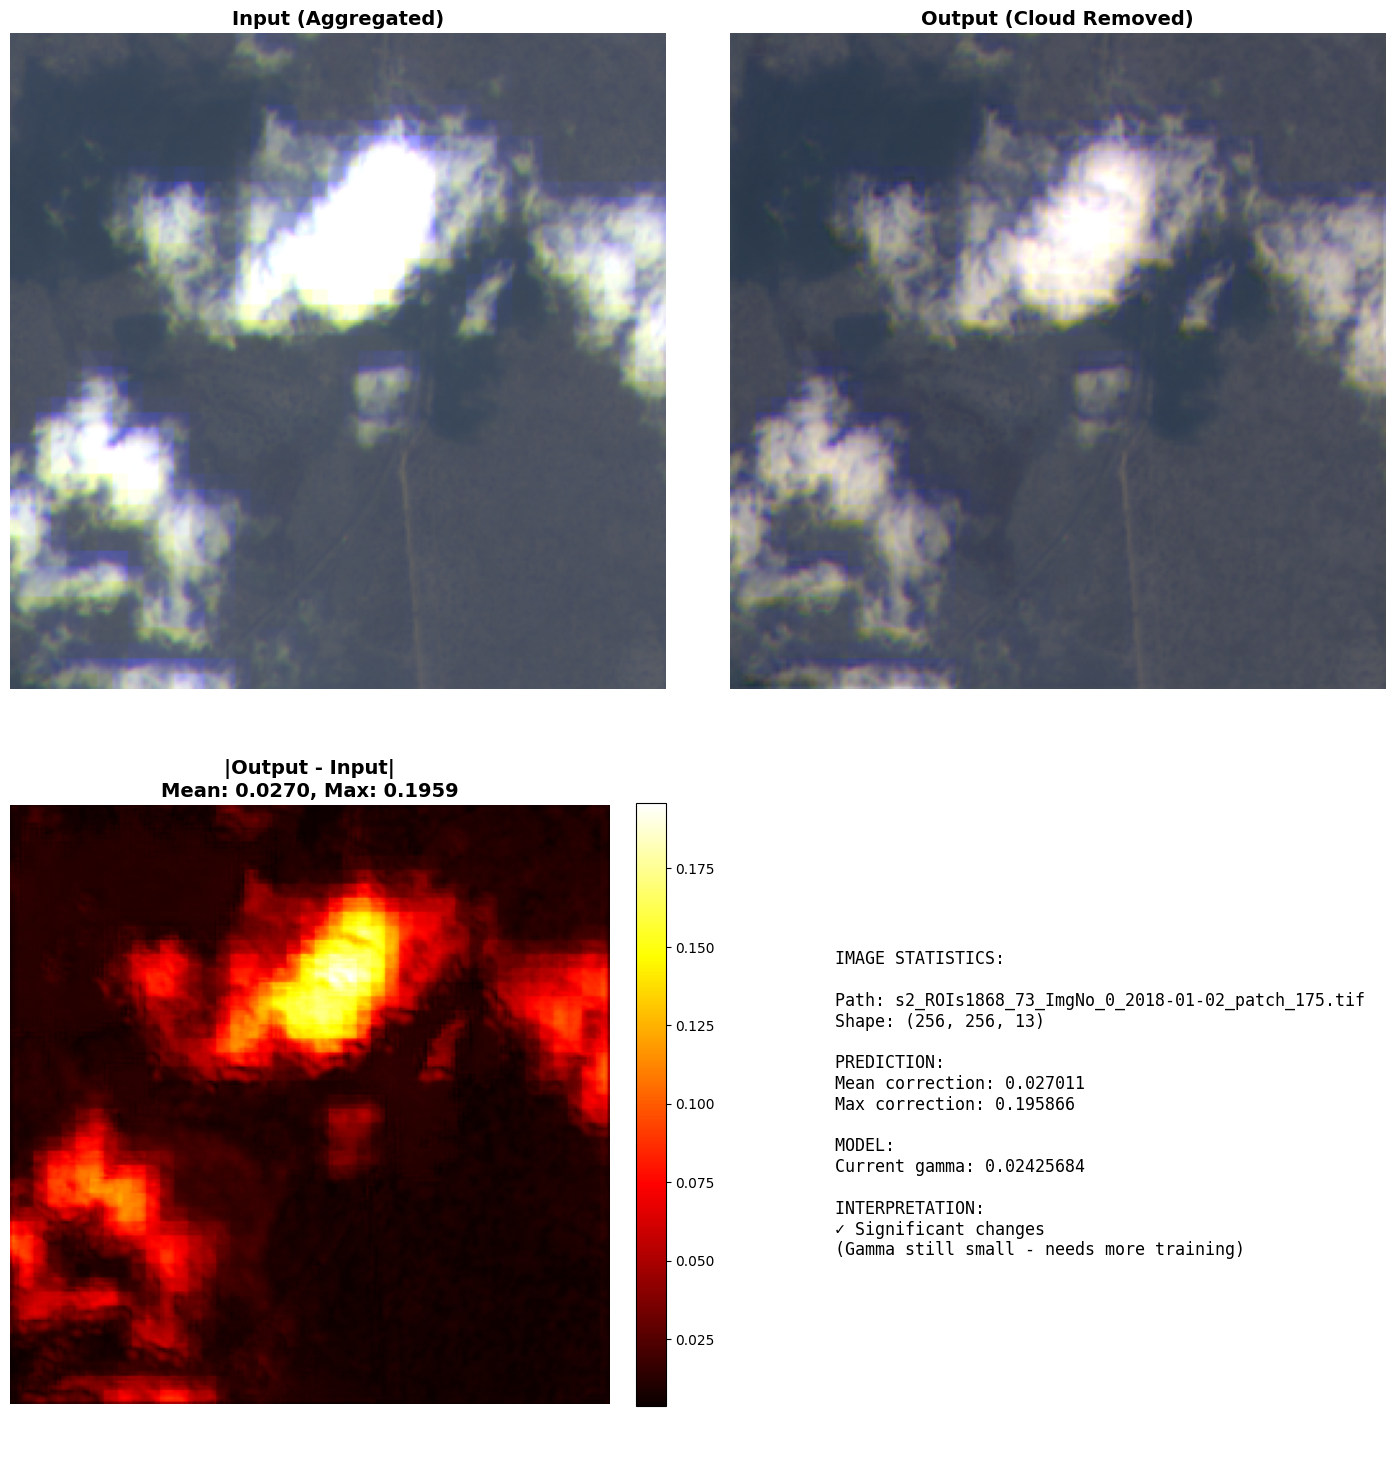


✓ Saved to: custom_prediction.png


In [48]:
# ============================================================
# TEST ON SPECIFIC IMAGE
# ============================================================

def test_specific_image(image_path, model=None):
    """
    Test the model on a specific image file
    """
    if model is None:
        print("Using current model in memory")
        test_model = globals()['model']
    else:
        test_model = model
    
    test_model.eval()
    
    # Load image
    print(f"Loading: {image_path}")
    img = load_tif(image_path)
    if img.shape[2] > 13:
        img = img[..., :13]
    
    print(f"Image shape: {img.shape}")
    print(f"Value range: [{img.min():.4f}, {img.max():.4f}]")
    
    # Normalize
    transform = A.Compose([
        A.Normalize(mean=[0.0]*13, std=[1.0]*13, max_pixel_value=1.0),
        ToTensorV2()
    ])
    
    img_t = transform(image=img)['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred = test_model(img_t)
    
    # Calculate difference
    diff = torch.abs(pred - img_t).mean(dim=1)[0].cpu().numpy()
    diff_mean = diff.mean()
    diff_max = diff.max()
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Input
    axes[0, 0].imshow(to_rgb(img_t[0]))
    axes[0, 0].set_title('Input (Aggregated)', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Output
    axes[0, 1].imshow(to_rgb(pred[0]))
    axes[0, 1].set_title('Output (Cloud Removed)', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Difference map
    im = axes[1, 0].imshow(diff, cmap='hot')
    axes[1, 0].set_title(f'|Output - Input|\nMean: {diff_mean:.4f}, Max: {diff_max:.4f}', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Statistics
    axes[1, 1].axis('off')
    stats_text = f"""
    IMAGE STATISTICS:
    
    Path: {os.path.basename(image_path)}
    Shape: {img.shape}
    
    PREDICTION:
    Mean correction: {diff_mean:.6f}
    Max correction: {diff_max:.6f}
    
    MODEL:
    Current gamma: {test_model.gamma.item():.8f}
    
    INTERPRETATION:
    {'✓ Significant changes' if diff_mean > 0.01 else '⚠ Small changes'}
    {'(Gamma still small - needs more training)' if test_model.gamma.item() < 0.1 else '(Gamma sufficient)'}
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                    verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('custom_prediction.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved to: custom_prediction.png")
    
    return pred.cpu().numpy()[0]

# ============================================================
# ✏️ CHANGE THESE PATHS TO TEST DIFFERENT IMAGES
# ============================================================

# Example 1: Test on a specific aggregated image
test_path_1 = r"D:\s2_asiaEast\asiaEast\ROIs1868\73\S2\0\s2_ROIs1868_73_ImgNo_0_2018-01-02_patch_175.tif"
# Example 2: Test on another patch
test_path_2 = r"D:\Timegate Images\ROIs1868_73\ROIs1868_73_S2_patch_5\2018-06-15_Fmask_composite_patch_5.tif"

# ============================================================
# RUN TESTS
# ============================================================

print("="*70)
print("TESTING ON CUSTOM IMAGES")
print("="*70)

# Test image 1
print("\n" + "="*70)
print("TEST 1")
print("="*70)
pred1 = test_specific_image(test_path_1)

# Uncomment to test more images:
# print("\n" + "="*70)
# print("TEST 2")
# print("="*70)
# pred2 = test_specific_image(test_path_2)